In [193]:
# Reload and core imports
%reload_ext autoreload
%autoreload 2

# All-in-one imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.ticker import FormatStrFormatter
from enum import Enum
from scipy.optimize import differential_evolution, minimize
from dolfin import *
from dolfin import Constant, Function, TestFunction, TrialFunction, VectorFunctionSpace, FunctionSpace, DirichletBC, Measure, assemble, dx, ds, inner, grad, div, sym, nabla_grad, sqrt, dot, outer, split, assign, interpolate
#from dolfin_adjoint import *
#from src.Optimiser import objective_function#, #spacing_constraint
#import objective_function, solve_tidal_flow_velocities_fast, update_turbine_field, setup_tidal_solver


from scipy.optimize import minimize, differential_evolution
from ufl import dot, div, grad, sqrt, nabla_grad, inner, outer, sym, measure
#from dolfin_adjoint import *

from petsc4py import PETSc

print("✅ Thesis SWE solver ready (v27-01)")

✅ Thesis SWE solver ready (v27-01)


In [227]:
# --- Physical and turbine parameters ---
rho = 1025.0         # Water density [kg/m³]
g = 9.81             # Gravitational acceleration [m/s²]
depth = 50.0         # Water depth [m]
nu = 1.0  # Effective viscosity [m²/s]

C_T = 0.7             # Turbine thrust coefficient [-]
C_D = 0.0025          # Drag coefficient [-]
D = 10               # Turbine diameter
sigma = 0.5*D         # Wake Gaussian spread [m]

A_T = np.pi*D**2            # Turbine swept area [m²]
Rated_power_per_turbine = 1e6  # Rated power per turbine [W]

# --- Flow properties ---
U_inflow = 2.0       # Inflow velocity [m/s]

# --- Initial conditions ---
initial_condition_u = Constant((2.0, 0.0))
initial_condition_eta = Constant(0.0) # Start with no surface elevation

#----Mesh parameters----
Lx, Ly = 600.0, 600.0
Nx, Ny = 60, 60

n_turbines = 8         # number of turbines
min_spacing = 2*D     # minimum spacing between turbines [m]

# --- Showing plots and info toggles ---
show_mesh_plot = True # toggle to plot the mesh
show_plot_turbines = True # toggle to show turbine layout plot
show_turbines_coordinates = True # toggle to show turbine coordinates
show_plot_velocity_field = True # toggle to plot velocity field
show_plot_power_field = False    # toggle to plot power field
show_single_turbine_info = True # toggle to show power and velocity per turbine

#distance from boundaries
distance_from_inlet = 10*D
distance_to_side = 10*D
distance_to_outlet = 10*D

#no slip or free slip if noslip = false -> free slip
noslip = False


#initial turbine positions toggle
class TurbineLayout(Enum): 
    RANDOM = 1
    STAGGERED = 2
    FENCE = 3

layout_param = TurbineLayout.FENCE # choose layout type here

print("Overview of parameter settings:")
print("--------------------------------")
print(f" - Turbine layout: {layout_param.name}")
print(f" - Number of turbines: {n_turbines}")
print(f" - Minimum turbine spacing: {min_spacing} m")   
print(f" - Domain size: {Lx} m x {Ly} m")
print(f" - Mesh: {Nx} x {Ny}")
print(f" - Type of boundary condition: {'No-slip' if noslip else 'Free-slip'}")
print("-------------------------------- ")
print("Other parameters:")
print(f" - Diameter of turbines: {D} m, thrust coefficient: {C_T}, drag coefficient: {C_D}, initial inflow velocity: {U_inflow} m/s, water depth: {depth} m, viscosity: {nu} m²/s")
    

Overview of parameter settings:
--------------------------------
 - Turbine layout: FENCE
 - Number of turbines: 8
 - Minimum turbine spacing: 20 m
 - Domain size: 600.0 m x 600.0 m
 - Mesh: 60 x 60
 - Type of boundary condition: Free-slip
-------------------------------- 
Other parameters:
 - Diameter of turbines: 10 m, thrust coefficient: 0.7, drag coefficient: 0.0025, initial inflow velocity: 2.0 m/s, water depth: 50.0 m, viscosity: 1.0 m²/s


In [235]:
def setup_swe_problem(Lx, Ly, Nx, Ny, U_inflow, showplot):
    # --- Domain and mesh setup ---
    mesh = RectangleMesh(Point(0.0, 0.0), Point(Lx, Ly), Nx, Ny)

    # --- Mixed Taylor–Hood function space ---
    P2 = VectorElement("P", mesh.ufl_cell(), 2)   # Quadratic velocity
    P1 = FiniteElement("P", mesh.ufl_cell(), 1)   # Linear free-surface
    mixed_element = MixedElement([P2, P1])
    W = FunctionSpace(mesh, mixed_element)

    # --- Define trial functions and test functions ---
    w = Function(W)           # Combined [u, eta]
    u, eta = split(w)
    v, q = TestFunctions(W)
    
    # --- Initialize uniform inflow velocity ---
    V_sub = W.sub(0).collapse()
    u_init = interpolate(Constant((2, 0.0)), V_sub)
    assign(w.sub(0), u_init)

    # --- Mesh visualization (optional) ---
    print(f"Success! Initialized u_init with U_inflow = {U_inflow} m/s "
          f"on a {Nx}x{Ny} mesh.")

    if not showplot:
        return mesh, W, w, u, eta, v, q
        
    plt.figure(figsize=(6, 5))
    plot(mesh)
    plt.title("Computational mesh verification")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.tight_layout()
    plt.show()

    return mesh, W, w, u, eta, v, q

def choose_turbine_layout(layout_param, Lx, Ly, n_turbines, sigma, min_spacing, distance_from_inlet, distance_to_side, distance_to_outlet):
    if layout_param == TurbineLayout.RANDOM:
        print("Placing turbines in random layout")
        initial_positions = place_turbines_random(
            Lx, Ly, n_turbines, sigma, min_spacing, 
            distance_from_inlet, distance_to_side, distance_to_outlet
        )
    elif layout_param == TurbineLayout.FENCE:
        print("Placing turbines in fence layout")
        initial_positions = place_turbines_fence(
            Lx, Ly, n_turbines, sigma, 
            distance_from_inlet, distance_to_side, distance_to_outlet, min_spacing
        )
    elif layout_param == TurbineLayout.STAGGERED:
        print("Placing turbines in staggered layout")
        initial_positions = place_turbines_staggered(
            Lx, Ly, n_turbines, sigma, min_spacing, 
            distance_from_inlet, distance_to_side, distance_to_outlet
        )
    else:
        raise ValueError("Unsupported turbine layout type.")
    
    return initial_positions

def place_turbines_staggered(Lx, Ly, n_turbines, sigma, min_spacing, 
                           distance_from_inlet, distance_to_side, distance_to_outlet):

    
    # Enforce placement rectangle
    xmin = distance_from_inlet 
    xmax = Lx - distance_to_outlet 
    ymin = distance_to_side 
    ymax = Ly - distance_to_side 

    if xmax <= xmin or ymax <= ymin:
        raise ValueError("Domain too small for requested placement bounds and margin")

    positions = []
    
    # Number of rows (staggered: 2 turbines per "unit")
    n_rows = (n_turbines + 1) // 2  # Ceiling division
    n_cols = 2                      # Alternating columns
    
    # Streamwise spacing (x-direction)
    spacing_x = max((xmax - xmin) / (n_rows + 1), 6*sigma)  # min 6σ apart
    
    # Spanwise spacing (y-direction, between rows)
    half_span = (ymax - ymin) / 2.0
    spacing_y = max(half_span / 2.0, 4*sigma)  # Offset rows
    
  
    for row in range(n_rows):
        x = xmin + (row + 1) * spacing_x
        
        if row % 2 == 0:  
            y1 = half_span + spacing_y * 0.5
            y2 = half_span - spacing_y * 1.5
        else:
            y1 = half_span + spacing_y * 1.5
            y2 = half_span - spacing_y * 0.5
            
        # Add turbines (prioritize fitting n_turbines)
        if len(positions) < n_turbines:
            positions.append([x, y1])
        if len(positions) < n_turbines:
            positions.append([x, y2])
    

    
    print(f"Placed {len(positions)} turbines in staggered layout "
          f"(rows: {n_rows}, span: {spacing_y:.1f}m)")
    return np.array(positions)



def place_turbines_random(Lx, Ly, n_turbines, sigma, min_spacing, distance_from_inlet, distance_to_side, distance_to_outlet, max_attempts=10000):
     # Enforce placement rectangle
    xmin = distance_from_inlet 
    xmax = Lx - distance_to_outlet 
    ymin = distance_to_side 
    ymax = Ly - distance_to_side 

    if xmax <= xmin or ymax <= ymin:
        raise ValueError("Domain too small for requested placement bounds and margin")

    positions = []
    attempts = 0

    while len(positions) < n_turbines and attempts < max_attempts:
        x = np.random.uniform(xmin, xmax/2)
        y = np.random.uniform(ymin, ymax)
        new_pos = np.array([x, y])

        if all(np.linalg.norm(new_pos - np.array(pos)) >= min_spacing for pos in positions):
            positions.append(new_pos)

        attempts += 1
    print(f"Managed to place {len(positions)} turbines within {attempts} attempts.")

    if len(positions) < n_turbines:
        raise RuntimeError("Failed to place all turbines with the given constraints.")
    else:
        print("Turbines placed successfully.")

    return np.array(positions)

def place_turbines_fence(Lx, Ly, n_turbines, sigma, distance_from_inlet, distance_to_side, distance_to_outlet, min_spacing):
    # Enforce placement rectangle
    xmin = distance_from_inlet 
    xmax = Lx - distance_to_outlet 
    ymin = distance_to_side 
    ymax = Ly - distance_to_side 

    if xmax <= xmin or ymax <= ymin:
        raise ValueError("Domain too small for requested placement bounds and margin")

    positions = []
    spacing = (ymax - ymin) / (n_turbines + 1)

    if spacing < min_spacing:
        raise ValueError("Not enough space to place turbines with the given minimum spacing.")
    
    print(min_spacing, spacing)
    
    for i in range(n_turbines):
        x = xmin # Centered in x-direction
        y = ymin + (i + 1) * spacing
        positions.append(np.array([x, y]))

    print(f"Placed {n_turbines} turbines in a fence layout.")

    return np.array(positions)

def set_up_bcs_and_markers(Lx, Ly, mesh, W, U_inflow, noslip):
    class InletBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0.0)

    class OutflowBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], Lx)

    class WallBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and (near(x[1], 0.0) or near(x[1], Ly))

    # --- Create and mark boundary facets ---
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
    inlet  = InletBoundary();  inlet.mark(boundary_markers, 1)
    outlet = OutflowBoundary(); outlet.mark(boundary_markers, 2)
    walls  = WallBoundary();   walls.mark(boundary_markers, 3)

    inflow_expr = Constant((U_inflow, 0.0))
    bc_inflow = DirichletBC(W.sub(0), inflow_expr, boundary_markers, 1)
    print(f"Boundary markers created and BCs applied:")
    print(f"   - Inlet  (ID=1): inflow velocity = {U_inflow:.2f} m/s")
    print( "   - Outlet (ID=2): open boundary (no Dirichlet BC)")

    if noslip:
        noslip  = dlf.Constant((0.0, 0.0))
        bc_wall = dlf.DirichletBC(W.sub(0), noslip, boundary_markers, 3)
        bcs = [bc_inflow, bc_wall]
        print( "   - Walls  (ID=3): no‑slip (Dirichlet BC)\n")

    else:
        bcs = [bc_inflow]
        print( "   - Walls  (ID=3): free‑slip (no Dirichlet BC)\n")

    return boundary_markers, bcs

def show_turbine_positions(initial_positions, showcoordinates):
    
    if showcoordinates:
        print("The initial turbine positions are:")
        for i, pos in enumerate(initial_positions):
            print(f" Turbine {i+1}: x = {pos[0]:.2f} m, y = {pos[1]:.2f} m")
    else:
        print("Turbine coordinates display not requested.")
    return

def plot_turbine_layout(mesh, turbine_positions, Lx, Ly, sigma, showplot):
    if not showplot:
        return 
    plt.figure(figsize=(7, 5))
    plot(mesh, linewidth=0.2, color="lightgray")

    for (x_i, y_i) in turbine_positions:
        plt.plot(x_i, y_i, 'ro', markersize=6)
        circle = plt.Circle(
            (x_i, y_i), 2*sigma,
            color='r', fill=False, linestyle='--', linewidth=1
        )
        plt.gca().add_artist(circle)

    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title(f"{layout_param.name} placement of {len(turbine_positions)} turbines")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def initial_estimate_nr_turbines(U_inflow, n_turbines, D, C_T, depth, Ly, Rated_power_per_turbine, distance_to_side):
    #this assumes fence

    ymin = distance_to_side 
    ymax = Ly - distance_to_side 

    y = ymax - ymin
  
    # Power density (seabed)
    density_m2 = 0.5 * rho * U_inflow**3   # W/m²

    # Power per unit width  
    density_m = 0.5 * rho * depth * U_inflow**3    # W/m

    # Total power
    total_power_available = density_m * y  # W

    Max_placeable_turbines = (y) / (D+2*D) +2  #assuming fence with spacing d on each side 

    #number of turbines estimate
    initial_guess_n_turbines = total_power_available / Rated_power_per_turbine

    if Max_placeable_turbines < initial_guess_n_turbines:  
        initial_guess_n_turbines = Max_placeable_turbines
        print(f"Warning: Only {Max_placeable_turbines:.0f} turbines can be placed in a fence layout with the given domain size and spacing constraints.")
    else:
        print(f"Maximum estimated number of turbines supported: {initial_guess_n_turbines:.0f} turbines")

    print(f"Seabed density: {density_m2/1e3:.1f} kW/m²")
    print(f"Per width:      {density_m/1e3:.0f} kW/m") 
    print(f"Total:          {total_power_available/1e6:.0f} MW")
    return initial_guess_n_turbines



Success! Initialized u_init with U_inflow = 2.0 m/s on a 60x60 mesh.


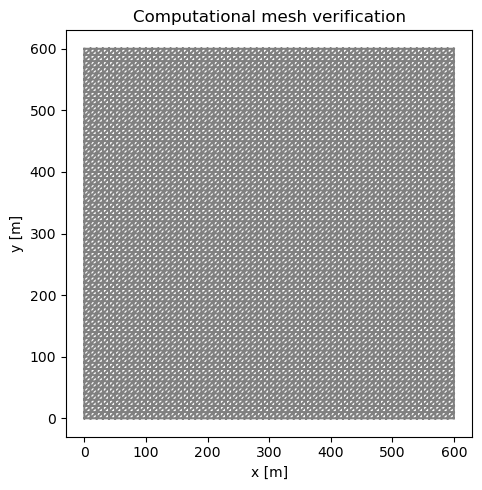

Seabed density: 4.1 kW/m²
Per width:      205 kW/m
Total:          82 MW
Initial guess for number of turbines: 15.0
Placing turbines in fence layout
20 25.0
Placed 15 turbines in a fence layout.
The initial turbine positions are:
 Turbine 1: x = 100.00 m, y = 125.00 m
 Turbine 2: x = 100.00 m, y = 150.00 m
 Turbine 3: x = 100.00 m, y = 175.00 m
 Turbine 4: x = 100.00 m, y = 200.00 m
 Turbine 5: x = 100.00 m, y = 225.00 m
 Turbine 6: x = 100.00 m, y = 250.00 m
 Turbine 7: x = 100.00 m, y = 275.00 m
 Turbine 8: x = 100.00 m, y = 300.00 m
 Turbine 9: x = 100.00 m, y = 325.00 m
 Turbine 10: x = 100.00 m, y = 350.00 m
 Turbine 11: x = 100.00 m, y = 375.00 m
 Turbine 12: x = 100.00 m, y = 400.00 m
 Turbine 13: x = 100.00 m, y = 425.00 m
 Turbine 14: x = 100.00 m, y = 450.00 m
 Turbine 15: x = 100.00 m, y = 475.00 m


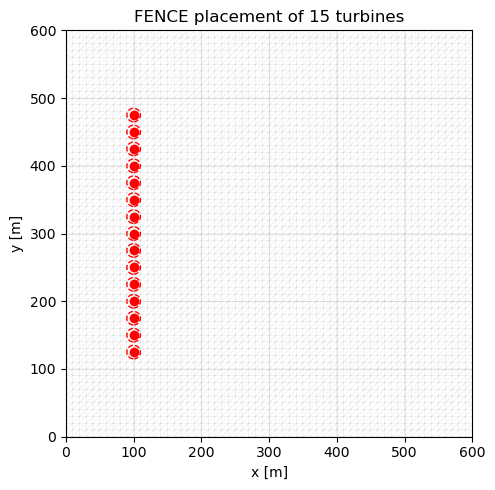

Boundary markers created and BCs applied:
   - Inlet  (ID=1): inflow velocity = 2.00 m/s
   - Outlet (ID=2): open boundary (no Dirichlet BC)
   - Walls  (ID=3): free‑slip (no Dirichlet BC)



In [236]:
#setting up mesh and initial turbine positions and boundary conditions and markers
mesh, W, w, u, eta, v, q = setup_swe_problem(
    Lx, Ly, Nx, Ny, U_inflow, show_mesh_plot
)

initial_guess_n_turbines = int(initial_estimate_nr_turbines(U_inflow, n_turbines, D, C_T, depth, Ly, Rated_power_per_turbine, distance_to_side))
print(f"Initial guess for number of turbines: {initial_guess_n_turbines:.1f}")

n_turbines = initial_guess_n_turbines

turbine_positions = choose_turbine_layout(
    layout_param, Lx, Ly, initial_guess_n_turbines, sigma, min_spacing, 
    distance_from_inlet, distance_to_side, distance_to_outlet
)

initial_turbine_positions = turbine_positions.copy()

show_turbine_positions(initial_turbine_positions, show_turbines_coordinates)
plot_turbine_layout(mesh, turbine_positions, Lx, Ly, sigma, show_plot_turbines)

boundary_markers, bcs = set_up_bcs_and_markers(Lx, Ly, mesh, W, U_inflow, noslip)

In [220]:
def solve_tidal_flow_velocities(
    turbine_positions, w, W, mesh, bcs, rho, depth, nu, cb, g, C_T, A_T, sigma):
    u_, eta_ = split(w)          # unknowns: velocity, free-surface
    v_, q_ = TestFunctions(W)    # test functions

    n = FacetNormal(mesh)
    H = depth + eta_             # total water depth
    f_u = Constant((0.0, 0.0))   # no internal body forcing

    # --- Turbine-induced momentum sink coefficient field ------------------
    x, y = SpatialCoordinate(mesh)

    Ct_field = 0
    for (x_i, y_i) in turbine_positions:
        Ct_field += (
            0.5 * C_T * A_T / (2.0 * np.pi * sigma**2)
            * exp(-((x - x_i)**2 + (y - y_i)**2) / (2.0 * sigma**2))
        )

    dx = Measure("dx", domain=mesh, metadata={"quadrature_degree": 4})  # P2 needs degree 4
    #dx_fine = Measure("dx", domain=mesh, metadata={"quadrature_degree": 8})

                     # Coarse elsewhere

    # --- Nonlinear residual form F ----------------------------------------
    F = (
        inner(nu * grad(u_), grad(v_)) * dx  # Fine near turbines
        + inner(dot(u_, nabla_grad(u_)), v_) * dx                      # advection
        - g * div(H * v_) * eta_ * dx                                  # free-surface coupling
        + (cb / H) * inner(u_ * sqrt(dot(u_, u_)), v_) * dx          # bottom friction
    )

    # Turbine momentum sink using spatially varying field
    F += (Ct_field / H) * inner(u_ * sqrt(dot(u_, u_)), v_) * dx

    # Continuity and body force term
    F += H * div(u_) * q_ * dx - inner(f_u, v_) * dx

    # --- Solve nonlinear problem with Newton's method ---------------------
    solve(
        F == 0,
        w,
        bcs,
        solver_parameters={
            "newton_solver": {
                "linear_solver": "mumps",
                "absolute_tolerance": 1e-8,
                "relative_tolerance": 1e-7,
                "maximum_iterations": 10,
                "relaxation_parameter": 1.0,
            }
        },
    )

    # --- Compute turbine power --------------------------------------------
   

    velocity = w.sub(0, deepcopy=True)
    turbine_powers, _ = compute_turbine_power(
        velocity, turbine_positions, rho, C_T, A_T
    )
    total_power = float(np.sum(turbine_powers))
    print(f"The total power is {total_power/1e3:.1f} kW")

    return total_power, velocity

def compute_turbine_power(velocity_function, turbine_positions, rho, C_T, A_T):
    powers, velocities = [], []

    for (x_i, y_i) in turbine_positions:
        u_local = velocity_function((x_i, y_i))
        speed = np.sqrt(u_local[0]**2 + u_local[1]**2)
        P_i = 0.5 * rho * C_T * A_T * speed**3
        powers.append(P_i)
        velocities.append(speed)

    return np.array(powers), np.array(velocities)

def summarize_turbine_power(powers, velocities, rho, C_T, A_T, U_inflow, n_turbines, show_single_turbine_info):
    if not show_single_turbine_info:
        return

    C_P = C_T * (1 - 0.5 * C_T)
    P_theoretical = 0.5 * rho * C_P * A_T * U_inflow**3
    P_thrust_based = 0.5 * rho * C_T * A_T * U_inflow**3
    Max_park_power = P_thrust_based * n_turbines

    total_power = np.sum(powers)

    print(f"Maximum theoretical power per turbine (Betz-adjusted): {P_theoretical/1e3:.2f} kW")
    print(f"Momentum-sink (raw thrust) power per turbine:          {P_thrust_based/1e3:.2f} kW")
    print(f"Max total power: {Max_park_power/1e6:.2f} MW  considering only number of turbines")
    print(f"Rated power taken into account: {Rated_power_per_turbine*n_turbines/1e6:.2f} MW")

    print("Turbine performance summary:")
    print("-" * 55)
    for i, (P, v) in enumerate(zip(powers, velocities), 1):
        print(f"Turbine {i:2d}: Velocity = {v:.2f} m/s | Power = {P/1e3:.2f} kW")
    print("-" * 55)
    print(f"Total extracted power: {total_power/1e6:.2f} MW")
    print(f"Fraction of park capacity: {total_power / Max_park_power * 100:.2f}%\n")

    # Optionally return numeric results
    return total_power, Max_park_power, P_theoretical, P_thrust_based 

Plot functions

In [221]:
def plot_velocity_field(w, turbine_positions, sigma, Lx, Ly, show_plot_velocity_field):
    if not show_plot_velocity_field:
        return
        
    velocity = w.sub(0, deepcopy=True)
    mesh = velocity.function_space().mesh()
    coords = mesh.coordinates()
    cells = mesh.cells()

    ux = velocity.sub(0).compute_vertex_values(mesh)
    uy = velocity.sub(1).compute_vertex_values(mesh)
    U = (ux**2 + uy**2)**0.5

    triang = Triangulation(coords[:, 0], coords[:, 1], cells)

    plt.figure(figsize=(8, 6))
    c = plt.tricontourf(triang, U, levels=50, cmap="viridis")
    cb = plt.colorbar(c, label="|u| [m/s]")

    # Force 2 decimal places on colorbar ticks
    cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Turbines
    for (x_i, y_i) in turbine_positions:
        plt.plot(x_i, y_i, "wo", markersize=6, markeredgecolor="k", zorder=5)

    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.title("Velocity field with turbine locations")
    plt.tight_layout()
    plt.show()


def plot_power_field(C_T, rho, A_T, w, turbine_positions, sigma, Lx, Ly, show_plot_power_field):
    if not show_plot_power_field:
        return
        
    velocity = w.sub(0, deepcopy=True)
    mesh = velocity.function_space().mesh()
    coords = mesh.coordinates()
    cells = mesh.cells()

    ux = velocity.sub(0).compute_vertex_values(mesh)
    uy = velocity.sub(1).compute_vertex_values(mesh)
    U = (ux**2 + uy**2)**0.5

    # Scale power density by 1e-6 for MW/m² display
    power_density_raw = 0.5 * rho * C_T * A_T * U**3
    power_density = power_density_raw / 1e6  # Convert to MW/m²

    triang = Triangulation(coords[:, 0], coords[:, 1], cells)

    plt.figure(figsize=(8, 6))
    c = plt.tricontourf(triang, power_density, levels=50, cmap="plasma")
    cb = plt.colorbar(c, label="Power density [MW/m²]")

    # Force 2 decimal places on colorbar ticks
    cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Mesh and turbines
    plt.triplot(triang, color="gray", linewidth=0.1, alpha=0.3)
    for (x_i, y_i) in turbine_positions:
        plt.plot(x_i, y_i, "wo", markersize=6, markeredgecolor="k", zorder=5)
        
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.title("Local power density and turbine locations")
    plt.tight_layout()
    plt.show()

First computation of powers of initial positions


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.226e+01 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 4.401e-01 (tol = 1.000e-08) r (rel) = 3.591e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 3.296e-03 (tol = 1.000e-08) r (rel) = 2.689e-04 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 3.482e-07 (tol = 1.000e-08) r (rel) = 2.841e-08 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
The total power is 15325.3 kW


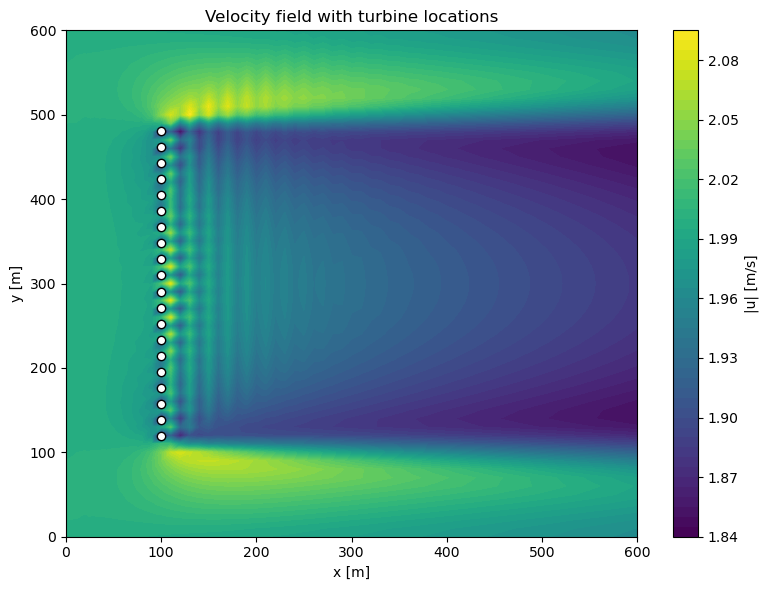

Maximum theoretical power per turbine (Betz-adjusted): 586.06 kW
Momentum-sink (raw thrust) power per turbine:          901.64 kW
Max total power: 18.03 MW  considering only number of turbines
Rated power taken into account: 20.00 MW
Turbine performance summary:
-------------------------------------------------------
Turbine  1: Velocity = 1.86 m/s | Power = 728.40 kW
Turbine  2: Velocity = 1.88 m/s | Power = 743.96 kW
Turbine  3: Velocity = 1.89 m/s | Power = 756.20 kW
Turbine  4: Velocity = 1.89 m/s | Power = 765.03 kW
Turbine  5: Velocity = 1.90 m/s | Power = 772.18 kW
Turbine  6: Velocity = 1.90 m/s | Power = 778.34 kW
Turbine  7: Velocity = 1.91 m/s | Power = 783.01 kW
Turbine  8: Velocity = 1.91 m/s | Power = 784.50 kW
Turbine  9: Velocity = 1.91 m/s | Power = 780.47 kW
Turbine 10: Velocity = 1.90 m/s | Power = 768.82 kW
Turbine 11: Velocity = 1.89 m/s | Power = 766.74 kW
Turbine 12: Velocity = 1.90 m/s | Power = 775.61 kW
Turbine 13: Velocity = 1.90 m/s | Power = 778.88 kW
Turbi

(15325256.833469896, 18032741.831605412, 586064.1095271759, 901637.0915802707)

In [222]:
init_total_power, init_velocity = solve_tidal_flow_velocities(turbine_positions, w, W, mesh, bcs, rho, depth, nu,
    C_D, g, C_T, A_T, sigma)

plot_velocity_field(w, turbine_positions, sigma, Lx, Ly, show_plot_velocity_field)
plot_power_field(C_T, rho, A_T, w, turbine_positions, sigma, Lx, Ly, show_plot_power_field)
powers, velocities = compute_turbine_power(init_velocity, turbine_positions, rho, C_T, A_T)
summarize_turbine_power(powers, velocities, rho, C_T, A_T, U_inflow, n_turbines, show_single_turbine_info)

In [138]:
def objective_function(x, w, W, mesh, bcs, rho, depth, nu, cb, g, C_T, A_T, sigma, D):
    n_turbines = len(x) // 2 #x is the position vector
    turbine_positions = [(x[2 * i], x[2 * i + 1]) for i in range(n_turbines)]
    
    # Compute total power from your existing solver
    total_power, _ = solve_tidal_flow_velocities(
        turbine_positions,
        w, W, mesh, bcs, rho, depth, nu, cb, g, C_T, A_T, sigma
    )
    
    # --- Enforce minimum spacing of turbines ---
    penalty = 0.0
    for i in range(n_turbines):
        for j in range(i + 1, n_turbines):
            dist = np.linalg.norm(np.array(turbine_positions[i]) - np.array(turbine_positions[j]))
            if dist < 5 * D:  # 5 rotor diameters
                penalty += (5 * D - dist) ** 2
    
    # Return negative total power because SciPy minimizes
    return -total_power + 1e6 * penalty


def run_scipy_optimizer(w, W, mesh, bcs, rho, depth, nu, C_D, C_T, A_T, sigma, D, 
                       n_turbines, Lx, Ly, initial_turbine_positions, 
                       distance_from_inlet, distance_to_side, distance_to_outlet):
    
    bounds = [(distance_from_inlet, Lx - distance_to_outlet), 
              (distance_to_side, Ly - distance_to_side)] * n_turbines

    optimizer_args = (w, W, mesh, bcs, rho, depth, nu, C_D, g, C_T, A_T, sigma, D)

    # Global optimization (SciPy adds x automatically)
    """"
    result_global = differential_evolution(
        objective_function,
        bounds,
        args=optimizer_args,  
        maxiter=1, 
        mutation = (0.5, 1.5),
        popsize=5, 
        recombination=0.85,
        tol=5e-3, 
        disp=True
    )
    print(f"\n Global search complete.")
    print(f"💕  Best preliminary objective (negative power): {result_global.fun:.3e}")"""
    print("\n👍 Refining solution locally with L‑BFGS‑B ...")

    initial_x = np.array([p[0] for p in initial_turbine_positions] + 
                     [p[1] for p in initial_turbine_positions])

    # Local refinement  
    result_local = minimize(
        objective_function,
        #result_global.x,  
        initial_x,
        args=optimizer_args,
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': False, 'maxiter': 5}
    )
    
    opt_positions = [(result_local.x[2*i], result_local.x[2*i+1]) for i in range(n_turbines)]
    opt_power = -result_local.fun
    
    print(f"Optimization complete! Power: {opt_power/1e6:.2f} MW")
    return opt_positions, opt_power, result_local


Optimiser

In [139]:
opt_positions, opt_power, result = run_scipy_optimizer(
    w, W, mesh, bcs, rho, depth, nu, C_D, C_T, A_T, sigma, D, 
    n_turbines, Lx, Ly, initial_turbine_positions, 
    distance_from_inlet, distance_to_side, distance_to_outlet
)


👍 Refining solution locally with L‑BFGS‑B ...
  Calling FFC just-in-time (JIT) compiler, this may take some time.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.457e+01 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 1.026e+00 (tol = 1.000e-08) r (rel) = 7.042e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 5.768e-03 (tol = 1.000e-08) r (rel) = 3.958e-04 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 2.375e-07 (tol = 1.000e-08) r (rel) = 1.630e-08 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
The total power is 4789.1 kW
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
  Calling FFC just-in-time (JIT) compiler,

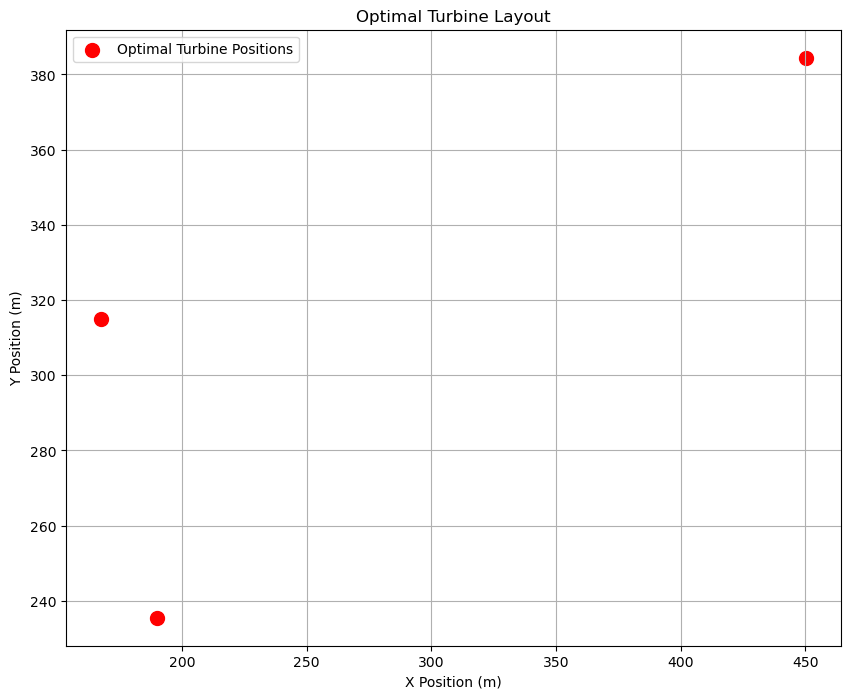

Optimal Turbine Positions:
Turbine 1: (189.95, 235.53)
Turbine 2: (167.48, 314.86)
Turbine 3: (450.14, 384.44)
Optimized Total Power: 2.19 MW


In [ ]:
#plotting optimal pos etc

plt.figure(figsize=(10, 8))
plt.scatter([p[0] for p in opt_positions], [p[1] for p in opt_positions], c='red', s=100, label='Optimal Turbine Positions')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Optimal Turbine Layout')
plt.grid(True)
plt.legend()
plt.show()

print("Optimal Turbine Positions:")
for i, pos in enumerate(opt_positions):
    print(f"Turbine {i+1}: ({pos[0]:.2f}, {pos[1]:.2f})")

print(f"Optimized Total Power: {opt_power/1e6:.2f} MW")




🎉 Final simulation with optimized turbine layout ...
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
The total power is 2193.7 kW
  Newton iteration 0: r (abs) = 4.002e-12 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


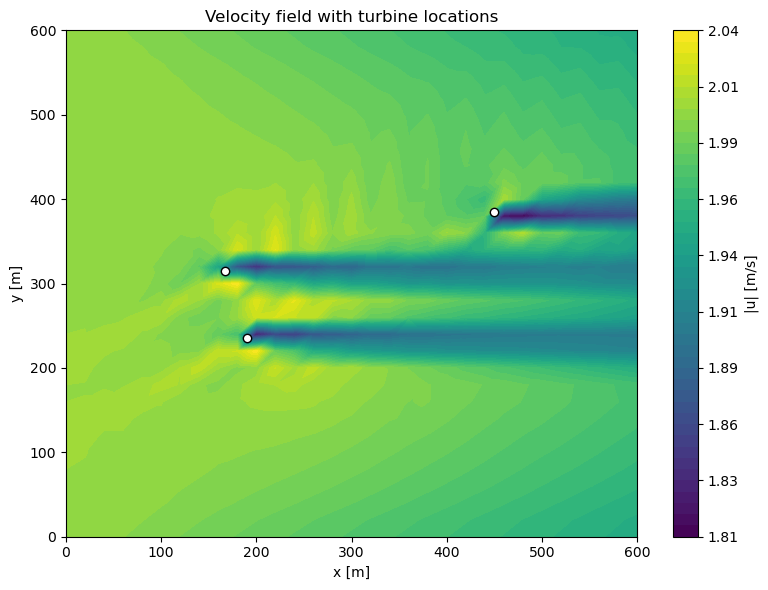

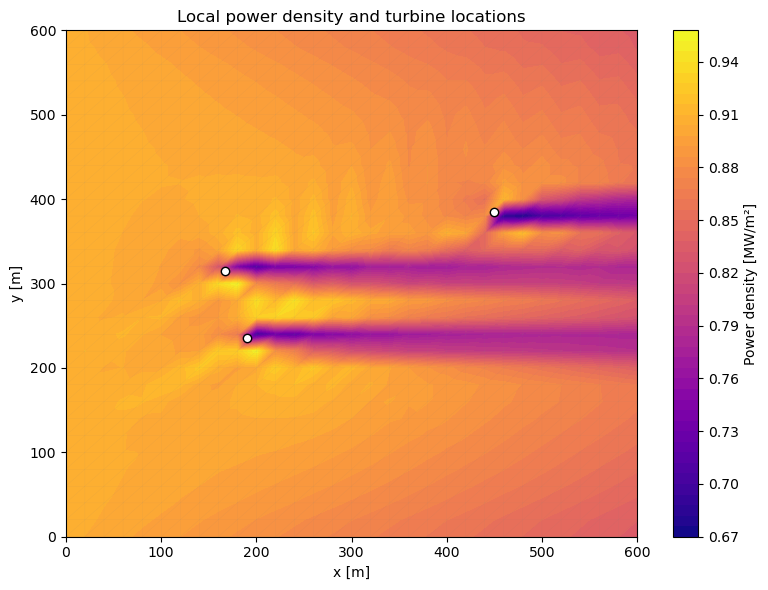

Maximum theoretical power per turbine (Betz-adjusted): 586.06 kW
Momentum-sink (raw thrust) power per turbine:          901.64 kW
Max total power: 2.70 MW

Turbine performance summary:
-------------------------------------------------------
Turbine  1: Velocity = 1.88 m/s | Power = 743.10 kW
Turbine  2: Velocity = 1.87 m/s | Power = 739.47 kW
Turbine  3: Velocity = 1.85 m/s | Power = 711.14 kW
-------------------------------------------------------
Total extracted power: 2.19 MW
Fraction of park capacity: 81.10%


========  LAYOUT OPTIMISATION SUMMARY  ========
Initial total power:                   2190.72 kW
Optimised total power:                 2193.71 kW
Relative improvement:                     0.14 %



In [ ]:

# ------------------------------------------------------------
#  CHOOSE FINAL RESULT
# ------------------------------------------------------------
print("\n🎉 Final simulation with optimized turbine layout ...")
final_total_power, final_velocity = solve_tidal_flow_velocities(
    opt_positions, w, W, mesh, bcs, rho, depth, nu, C_D, g, C_T, A_T, sigma
)

plot_velocity_field(w, opt_positions, sigma, Lx, Ly, show_plot_velocity_field)
plot_power_field(C_T, rho, A_T, w, opt_positions, sigma, Lx, Ly, show_plot_power_field=True)
powers, velocities = compute_turbine_power(final_velocity, opt_positions, rho, C_T, A_T)
summarize_turbine_power(powers, velocities, rho, C_T, A_T, U_inflow, n_turbines, show_single_turbine_info)  


# --- Compute relative improvement and efficiency ---
improvement_pct = (final_total_power - init_total_power) / init_total_power * 100
#efficiency_pct = final_total_power / opt_max_park_power * 100

# --- Print clean summary ---
print("\n========  LAYOUT OPTIMISATION SUMMARY  ========")
print(f"{'Initial total power:':35s} {init_total_power/1e3:10.2f} kW")
print(f"{'Optimised total power:':35s} {final_total_power/1e3:10.2f} kW")
#print(f"{'Maximum theoretical power (no wake):':35s} {opt_max_park_power/1e6:10.2f} MW")
print(f"{'Relative improvement:':35s} {improvement_pct:10.2f} %")
#print(f"{'Farm efficiency:':35s} {efficiency_pct:10.2f} %")
print("===============================================\n")

